DC2 DESI Selection
================

Script for selecting "spectroscopic" reference objects from DC2 era datasets.

This dataset is meant to mimic the DESI selection as a function of redshift for 4 samples: Luminous Red Galaixes (LRGs), Emission Line Galaxies (ELGs), a magnitude limited sample, and high redshift quasars (QSOs).

Numbers are from the DESI final design document: http://desi.lbl.gov/wp-content/uploads/2014/04/fdr-science-biblatex.pdf and from private communication with Jeff Newman and Rongpu Zhou.

This code is currently structured to work on protoDC2 only. Some more scripting will be required when the full DC2 truth dataset becomes available.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import GCRCatalogs
from GCR import GCRQuery

Load bin edges and density values for samples from the DESI FDR.

In [2]:
bin_edges = np.concatenate(
    [np.arange(0.60, 1.95, 0.1),
     [2.02, 2.22, 2.34, 2.52, 2.66,
      2.84, 2.98, 3.16, 3.30, 3.48,
      3.62, 3.78, 3.94, 4.10]])
delta_zs = bin_edges[1:] - bin_edges[:-1]
# Initial density values are in units, N / (deg^2 dz)
# hence multiplying by the redshift bin width.
ELG_density = np.array( # units: N / degree^2
    [ 309, 2269, 1923, 2094, 1441, 1353,  523,  466,
      329,  126,    0,    0, 0,    0,    0,    0,
        0,    0,    0,    0, 0,    0,    0,    0,
        0,    0,    0]) * delta_zs 
QSO_density = np.array(# units: N / degree^2
    [47, 55, 61, 67, 72, 76, 80, 83,
     85, 87, 87, 87, 86, 82, 69, 53,
     43, 37, 31, 26, 21, 16, 13,  9,
      7,  5,  3]) * delta_zs

Rongpu kindly provided more recent density estimates for LRGs detected in DESI. These are provided in redshift bins with a width of delta z=0.01. For protoDC2 this is currently to fine of a binning for the ammount of data available so we smooth it to a binning similar to that of the other densities, delta_z=0.1.

In [3]:
lrg_density = np.loadtxt(
    '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/'
    'DESI_reference_redshifts/lrg_densities_20180725.txt')
lrg_smoothed_bin_edges = np.arange(0.25, 1.26, 0.1)
print(lrg_smoothed_bin_edges)
lrg_smoothed_densities = np.zeros(len(lrg_smoothed_bin_edges) - 1)
for bin_idx in range(10):
    lrg_smoothed_densities[bin_idx] = lrg_density[
        10*bin_idx:10 * (bin_idx + 1), 2].sum()

[ 0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15  1.25]


Load the protoDC2 catalog

In [4]:
catalog = GCRCatalogs.load_catalog('proto-dc2_v5.0')

In [5]:
def create_redshift_stellar_prop_selection(z_bin_mins,
                                           z_bin_maxes,
                                           goal_number_densities,
                                           mag_name='mag_r_lsst',
                                           mag_lim=23.4,
                                           cut_dict=None,
                                           selection='totalStarFormationRate'):
    """Compute star formation rate or stellar mass cuts in redshifts bins given a
    set of bin edges and expected densities.
    
    Paramters
    ---------
    z_bin_mins : `float` array-like
        Minimum bin redshifts.
    z_bin_maxes : `float` array-like
        Maximum bin redshifts.
    goal_number_densities : `float` array-like
        Number of expected objects per redshift bin. Should be in units counts.
    mag_name : `str`
        Name of the magnitude column to cut on.
    mag_lim : `float`
        Maximum value of the magnitude obseved in mag_name.
    cut_dict : `dict`
        Dictionary of float arrays from a pervious selection run in this method.
    selection : `string`
        Column to select stellar properites. Valid choices are stellar_mass and
        totalStarFormationRation.
        
    Returns
    -------
    output : `dict`
        Dictionary of bin edges.
    """
    
    columns = [mag_name, 'redshift', 'totalStarFormationRate', 'stellar_mass']
    
    #Pre-cut selections. Magnitude cut avoids duplication of objects from the DESI
    # magnitude limiting cut.
    start_cut = [
        GCRQuery('%s < %.1f' % (mag_name, mag_lim)),
        GCRQuery('redshift > %.2f' % np.min(z_bin_mins)),
        GCRQuery('redshift <= %.2f' % np.max(z_bin_maxes)),
        GCRQuery('mag_r_lsst >= 19.5')
    ]

    data = catalog.get_quantities(columns, filters=start_cut)
    
    #Initialize data output dict.
    output = {"z_min": z_bin_mins,
              "z_max": z_bin_maxes,
              "mag_lim": np.full(len(z_bin_maxes), mag_lim),
              "sfr_min": np.full(len(z_bin_maxes), -99),
              "sfr_max": np.full(len(z_bin_maxes), -99),
              "stm_min": np.full(len(z_bin_maxes), -99),
              "stm_max": np.full(len(z_bin_maxes), -99),
              "mag_name": mag_name}
        
    for bin_idx, (z_min, z_max, n_goal) in enumerate(
            zip(z_bin_mins, z_bin_maxes, goal_number_densities)):

        mask = np.logical_and(data['redshift'] > z_min,
                              data['redshift'] <= z_max)
        
        #If an input dict has been provided, select on totalStarFormationRate
        #as defined by the dictionary. This allows for the removal of objects
        #previously selected from a sample making each selection a set of
        #independent objects.
        if cut_dict is not None:
            #The redshift binning of objects to exlude may be mismatched to the
            #current bin edges we consider. This bit of code is to look up the
            #values where bins overlap and reports that value. It assumes that the
            #binning for the cut_dict is larger than that of the requsted binning.
            #This will become superfulous later thanks to more data and usages of
            #splining of the bin densities.
            cut_bin_min_idx = np.searchsorted(cut_dict["z_min"], z_min)
            if cut_bin_idx > 0 and cut_bin_idx <= len(cut_dict["z_min"]) and \
               cut_dict['sfr_min'][cut_bin_idx - 1] > 0:
                mask = np.logical_and(mask,
                                      data['totalStarFormationRate'] <=
                                      cut_dict['sfr_min'][cut_bin_idx - 1])
                output['sfr_max'][bin_idx] = cut_dict['sfr_min'][cut_bin_idx - 1]
        stellar_array = data[selection][mask]

        if len(stellar_array) == 0:
            continue
        elif len(stellar_array) < n_goal:
            n_goal = len(stellar_array)
        stellar_array.sort()
        
        if selection == 'totalStarFormationRate':
            output['sfr_min'][bin_idx] = stellar_array[-np.int(np.ceil(n_goal))]
        elif selection == 'stellar_mass':
            output['stm_min'][bin_idx] = stellar_array[-np.int(np.ceil(n_goal))]
            
    return output

We then use the above selection to create selections to simulate different samples in DESI. These are done progessively to assure that each sample is independent.

We first select QSOs as the highest star formation rate (SFR) objects as a function of redshift with a magnitude cut of r<24.3. The selection for ELGs uses similar criteria but uses the minimum SFR of of the QSO selectoin as the maximum for this selection. Similarlly for LRGs, the max SFR allowed is the minimum SFR of the ELGs.

The LRG selection differes slight as they are selected by z-band magnitude and stellar mass. Again, though, they are selected to be the largest stellar mass objects while also excluding any possible overlap with the ELG and QSO samples.

All samples are also selected to be fainter than r=19.5 to avoid overlap with the magnitude limited sample.

In [6]:
qso_dict = create_redshift_stellar_prop_selection(
    bin_edges[:-1],
    bin_edges[1:],
    QSO_density * catalog.sky_area,
    selection='totalStarFormationRate',
    mag_name="mag_r_lsst",
    mag_lim=23.4)
elg_dict = create_redshift_stellar_prop_selection(
    bin_edges[:-1],
    bin_edges[1:],
    ELG_density * catalog.sky_area,
    cut_dict=qso_dict,
    selection='totalStarFormationRate',
    mag_name="mag_r_lsst",
    mag_lim=23.4)
lrg_dict = create_redshift_stellar_prop_selection(
    lrg_smoothed_bin_edges[:-1],
    lrg_smoothed_bin_edges[1:],
    lrg_smoothed_densities * catalog.sky_area,
    cut_dict=elg_dict,
    selection='stellar_mass',
    mag_name="mag_z_lsst",
    mag_lim=23.0)

In [7]:
def select_from_GCR(cat, columns, selection_dict):
    """Select requested data from the GCR with the requested columns and
    selections defined in selection_dict.
    
    Parameters
    ----------
    cat : `GCRCatalogs.Catalog`
        DC2 GCRCatalog object.
    columns : `list` of `str`s
        List of columns names to load.
    selection_dict : `dict` of values
        Output of the `create_redshift_stellar_prop_selection` method.
        
    Returns
    -------
    output : `dict` of values
        Dictionary of catalog columns meeting the selection criteria in
        `selection_dict`.
    """
    
    output = {}
    for col in columns:
        output[col] = []

    for bin_idx in range(len(selection_dict['z_min'])):
        queries = [GCRQuery("redshift > %.2f" % selection_dict["z_min"][bin_idx]),
                   GCRQuery("redshift <= %.2f" % selection_dict["z_max"][bin_idx]),
                   GCRQuery("%s < %.2f" % (selection_dict["mag_name"],
                                           selection_dict["mag_lim"][bin_idx]))]
        if selection_dict["sfr_min"][bin_idx] > 0:
            queries.append(
                GCRQuery("totalStarFormationRate > %.2f" %
                         selection_dict["sfr_min"][bin_idx]))
        if selection_dict["sfr_max"][bin_idx] > 0:
            queries.append(GCRQuery("totalStarFormationRate <= %.2f" %
                                    selection_dict["sfr_max"][bin_idx]))
        if selection_dict["stm_min"][bin_idx] > 0:
            queries.append(GCRQuery("stellar_mass > %.2f" %
                                    selection_dict["stm_min"][bin_idx]))
        if selection_dict["stm_max"][bin_idx] > 0:
            queries.append(GCRQuery("stellar_mass <= %.2f" %
                                    selection_dict["stm_max"][bin_idx]))
        
        data = cat.get_quantities(columns, filters=queries)
        for col in columns:
            output[col].append(data[col])
            
    for col in columns:
        output[col] = np.concatenate(output[col])
        
    return output

Specify the columns to store for the DESI-like spectrocopic sample and select the samples using the output selection dicts.

Additionally, create a magnitude limited sample of objects up to r=19.5

In [8]:
columns = ['galaxy_id', 'ra', 'dec', 'redshift',
           'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst',
           'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst',
           'stellar_mass', 'totalStarFormationRate']

qsos = select_from_GCR(catalog, columns, qso_dict)
elgs = select_from_GCR(catalog, columns, elg_dict)
lrgs = select_from_GCR(catalog, columns, lrg_dict)

In [9]:
mag_lims = catalog.get_quantities(columns, filters=[GCRQuery("mag_r_lsst < 19.5")])

Check-plot of the number versious redshift for our samples. The solid color is the native binning of the sample and the dashed are redshift bins of delta_z=0.01.

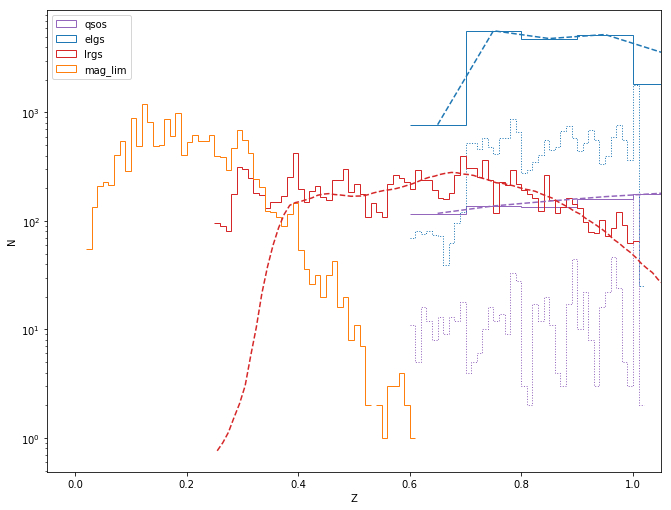

In [19]:
plt.figure(figsize=(11, 8.5))
plt.hist(qsos['redshift'], bins=bin_edges, histtype='step', label='qsos',
         color='C4')
plt.hist(qsos['redshift'], bins=np.arange(0, 1.05, 0.01), histtype='step',
         color='C4', ls=':')
plt.plot(bin_edges[:-1] + delta_zs / 2.0, QSO_density * catalog.sky_area, ls='--',
         color='C4')
plt.hist(elgs['redshift'], bins=bin_edges, histtype='step', label='elgs',
         color='C0')
plt.hist(elgs['redshift'], bins=np.arange(0, 1.05, 0.01), histtype='step',
         color='C0', ls=':')
plt.plot(bin_edges[:-1] + delta_zs / 2.0, ELG_density * catalog.sky_area, ls='--',
         color='C0')
plt.hist(lrgs['redshift'], bins=np.arange(0, 1.05, 0.01), histtype='step',
         label='lrgs',
         color='C3')
plt.plot(lrg_density[:, 0]  + 0.005, lrg_density[:, 2] * catalog.sky_area, ls='--',
         color='C3')
plt.hist(mag_lims['redshift'], bins=np.arange(0, 1.05, 0.01), histtype='step',
         label='mag_lim', color='C1')

plt.semilogy()
plt.xlim(-0.05, 1.05)
plt.legend(loc=0)
plt.xlabel('Z')
plt.ylabel('N')

Color-color and color-redshift diagrams to inspect the resulting distribution of the selected galaxies. For protoDC2_v5.0 these seem reasonable according to those I've spoken to.

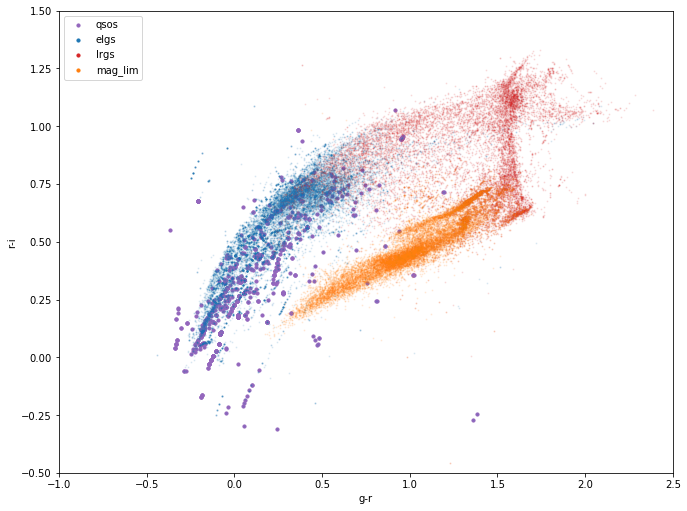

In [21]:
plt.figure(figsize=(11, 8.5))
plt.scatter(qsos['mag_g_lsst'] - qsos['mag_r_lsst'],
            qsos['mag_r_lsst'] - qsos['mag_i_lsst'],
            alpha=1, s=10, color='C4', label='qsos')
plt.scatter(elgs['mag_g_lsst'] - elgs['mag_r_lsst'],
            elgs['mag_r_lsst'] - elgs['mag_i_lsst'],
            alpha=0.1, s=1, color='C0')
plt.scatter([-100],
            [-100],
            s=10, color='C0', label='elgs')
plt.scatter(lrgs['mag_g_lsst'] - lrgs['mag_r_lsst'],
            lrgs['mag_r_lsst'] - lrgs['mag_i_lsst'],
            alpha=0.1, s=1, color='C3')
plt.scatter([-100],
            [-100],
            s=10, color='C3', label='lrgs')
plt.scatter(mag_lims['mag_g_lsst'] - mag_lims['mag_r_lsst'],
            mag_lims['mag_r_lsst'] - mag_lims['mag_i_lsst'],
            alpha=0.1, s=1, color='C1')
plt.scatter([-100],
            [-100],
            s=10, color='C1', label='mag_lim')
plt.xlim(-1, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r-i')

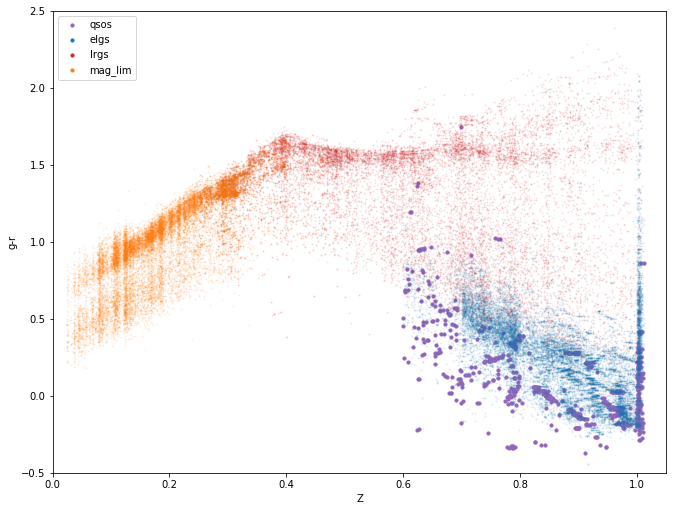

In [23]:
plt.figure(figsize=(11, 8.5))
plt.scatter(qsos['redshift'], qsos['mag_g_lsst'] - qsos['mag_r_lsst'],
            alpha=1, s=10, color='C4', label='qsos')
plt.scatter([-100],
            [-100],
            s=10, color='C0', label='elgs')
plt.scatter(elgs['redshift'], elgs['mag_g_lsst'] - elgs['mag_r_lsst'],
            alpha=0.1, s=1, color='C0')
plt.scatter([-100],
            [-100],
            s=10, color='C3', label='lrgs')
plt.scatter(lrgs['redshift'], lrgs['mag_g_lsst'] - lrgs['mag_r_lsst'],
            alpha=0.1, s=1, color='C3')
plt.scatter([-100],
            [-100],
            s=10, color='C1', label='mag_lim')
plt.scatter(mag_lims['redshift'], mag_lims['mag_g_lsst'] - mag_lims['mag_r_lsst'],
            alpha=0.1, s=1, color='C1')
plt.xlim(0, 1.05)
plt.ylim(-0.5, 2.5)
plt.legend()
plt.xlabel('Z')
plt.ylabel('g-r')

Finally, we write the data selected to dist inside of the photo-z DC2 directory, `/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/`.

In [13]:
from astropy.io import fits

In [14]:
def save_DESI_data(data, columns, output_name):
    """Take the output of the GCR and save it to fits format.
    
    Parameters
    ----------
    data : `dict` of array-likes
        Catalog data to store.
    columns : `list` of `str`s
        String names of catalog columns to create in the fits table
        and copy from the input `data`.
    output_name : `str`
        Full path name of the new file to write to.
    """

    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E'}
    fits_columns = []
    for col in columns:
        fits_columns.append(fits.Column(name=col, array=data[col],
                                        format=dtype_to_fits_type[str(data[col].dtype)]))
    output = fits.BinTableHDU.from_columns(fits_columns)
    
    output.writeto(output_name, overwrite=True)

In [15]:
save_DESI_data(
    qsos, columns,
    '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/DESI_reference_redshifts/'
    'DESI_QSOs.fits')

In [16]:
save_DESI_data(
    elgs, columns,
    '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/DESI_reference_redshifts/'
    'DESI_ELGs.fits')

In [17]:
save_DESI_data(
    lrgs, columns,
    '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/DESI_reference_redshifts/'
    'DESI_LRGs.fits')

In [18]:
save_DESI_data(
    mag_lims, columns,
    '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/DESI_reference_redshifts/'
    'DESI_mag_lim.fits')